## Imports

In [148]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm

In [149]:
# read in training dataframe
train_df = pd.read_csv('datasets/train.csv')
# display first 5 rows to evaluate
train_df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


In [150]:
# clean column names with no spaces and all lower case
train_df.columns = train_df.columns.str.lower().str.replace(' ', '_')

In [151]:
# Create custom pipe with the knowledge and help of Chuck
def custom_pipe(df):
    # set X or independent variables
    X = df[['overall_cond', 
                'overall_qual', 
                'exter_qual',
                'exter_cond',
                'garage_finish',
                'garage_cars',
                'garage_cond',
                'garage_area',
                'garage_qual',
                'bsmt_qual',
                'bsmt_cond',
                'bsmt_exposure',
                'total_bsmt_sf',  
                'kitchen_qual', 
                'fireplace_qu', 
                'fireplaces',
                'year_built',
                'year_remod/add',
                'full_bath',
                'half_bath',
                'bedroom_abvgr',
                'totrms_abvgrd',
                '2nd_flr_sf',
                'gr_liv_area',
                'bsmtfin_type_1',
                'bsmtfin_sf_1',
                '1st_flr_sf',
                'ms_zoning',
                'neighborhood']]
    X.fillna(0, inplace=True)
    # set up a dict for mapping of ordinal data columns
    ordinal_dict = {
        'Ex' : 5,
        'Gd' : 4,
        'TA' : 3,
        'Fa' : 2,
        'Po' : 1,
        'NA' : 0,
        0    : 0}
    garage_finish_dct = {
        'Fin':3,
        'RFn':2,
        'Unf':1,
        'NA' :0,
        0    :0}
    bmt_exposure_dct = {
        'Gd':4,
        'Av':3,
        'Mn':2,
        'No':1,
        'NA':0,
        0   :0}
    bmt_fin_type_dct = {
    'GLQ':5,
    'ALQ':4,
    'BLQ':3,
    'Rec':3,
    'LwQ':2,
    'Unf':1,
    'NA':0,
    0   :0}
    nbhd_dct = {
    'StoneBr' : 3, 
    'NridgHt' : 3, 
    'NoRidge' : 3, 
    'GrnHill' : 3, 
    'Veenker' : 3, 
    'Timber' : 3, 
    'Somerst' : 3,
    'ClearCr' : 3, 
    'Crawfor': 2, 
    'CollgCr':2, 
    'Blmngtn':2, 
    'NWAmes':2, 
    'Gilbert':2, 
    'Greens':2, 
    'SawyerW':2, 
    'Mitchel':2, 
    'NAmes':2, 
    'Blueste' : 2,
    'NPkVill':1,
    'Sawyer':1, 
    'Landmrk':1, 
    'SWISU':1, 
    'Edwards':1, 
    'BrkSide':1, 
    'OldTown':1, 
    'BrDale':1, 
    'IDOTRR':1, 
    'MeadowV':1}
    ms_zone_dct = {
    'RL':1,
    'RM':1,
    'FV':1,
    'C (all)':0,
    'RH':1,
    'A (agr)':0,
    'I (all)':0,
     0:0}
    #casting values based on the dictionary above 
    X['bsmt_cond'] = X['bsmt_cond'].map(ordinal_dict)
    X['bsmt_qual'] = X['bsmt_qual'].map(ordinal_dict)
    X['bsmt_exposure'] = X['bsmt_exposure'].map(bmt_exposure_dct)
    X['exter_cond'] = X['exter_cond'].map(ordinal_dict)
    X['exter_qual'] = X['exter_qual'].map(ordinal_dict)
    X['garage_cond'] = X['garage_cond'].map(ordinal_dict)
    X['garage_qual'] = X['garage_qual'].map(ordinal_dict)
    X['kitchen_qual'] = X['kitchen_qual'].map(ordinal_dict)
    X['garage_finish'] = X['garage_finish'].map(garage_finish_dct)
    X['fireplace_qu'] = X['fireplace_qu'].map(ordinal_dict)
    X['bsmtfin_type_1'] = X['bsmtfin_type_1'].map(bmt_fin_type_dct)
    X['neighborhood'] = X['neighborhood'].map(nbhd_dct)
    X['ms_zoning'] = X['ms_zoning'].map(ms_zone_dct)
    #feature extraction 
    X['year_built'] = 2010 - X['year_built']
    X['year_remod/add'] = 2010 - X['year_remod/add']
    #feature interactions
    #basement
    X['total_basement'] = X['bsmt_qual'] * X['total_bsmt_sf'] * X['bsmt_cond']
    X['bsmt_1_total'] = X['bsmtfin_type_1'] * X['bsmtfin_sf_1']
    # garage
    X['total_garage']=X['garage_cond']* X['garage_qual'] * X['garage_finish'] * X['garage_area']
    X['garage_area_cars']=X['garage_area'] * X['garage_cars']
    # living areas
    X['social_area_qual'] = X['gr_liv_area'] * X['kitchen_qual'] 
    X['total_bath'] = X['full_bath'] + X['half_bath']
    X['all_fireplace'] = X['fireplace_qu']*X['fireplaces']
    #2nd floor
    X['abv_rooms'] = X['totrms_abvgrd'] * X['bedroom_abvgr'] * X['2nd_flr_sf']
    #overall assessment
    X['overall_qual_cond'] = X['overall_cond'] * X['overall_qual']
    X['exter_overall'] = X['exter_cond'] * X['exter_qual']
    X['ages'] = X['year_built'] * X['year_remod/add']
    X['total_sf'] = X['1st_flr_sf'] * X['2nd_flr_sf'] * X['total_bsmt_sf']
    # area of living
    X['ames_zone_nbhood'] = X['neighborhood'] * X['ms_zoning']
    
    try:
        y = df['saleprice']
    except:
        y = 0
    return(X,y)

In [152]:
# Execute custom pipe on training data
X,y = custom_pipe(train_df)

In [153]:
# Assign X and y to test_train_split
X_train,X_test,y_train,y_test = train_test_split(X, y, train_size=.8, random_state=42)

In [154]:
# Initiate Linear Regression
linreg=LinearRegression()

In [155]:
# Fit linear regression model to X_train and y_train
linreg.fit(X_train, y_train)

LinearRegression()

In [156]:
# Score linear regression on X_train and y_train
linreg.score(X_train,y_train)

0.8638041850801111

In [157]:
# Score linear regression on X_test and y_test
linreg.score(X_test,y_test)

0.8965422385720223

In [158]:
# Print Linear regression train, test, and cross val scores
print(f"Training R2: {linreg.score(X_train, y_train)}")
print(f"Testing R2: {linreg.score(X_test, y_test)}")
print(f"Cross val R2: {cross_val_score(linreg, X, y).mean()}")

Training R2: 0.8638041850801111
Testing R2: 0.8965422385720223
Cross val R2: 0.7501815736998763


#### Summary Stats of Ordinary Least Squares

In [159]:
X = sm.add_constant(X)
ols= sm.OLS(y, X).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     330.9
Date:                Fri, 16 Jul 2021   Prob (F-statistic):               0.00
Time:                        22:22:31   Log-Likelihood:                -23946.
No. Observations:                2051   AIC:                         4.798e+04
Df Residuals:                    2009   BIC:                         4.821e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              6750.5887   4.51e+04      0.150      0.881   -8.18e+04    9.53e+04
overall_cond       4645.4061   2629.630      1.767      0.077    -511.680    9802.493
overall_qual       8325.3231   2715.778      3.066      0.002    2999.287    1.37e+04
exter_qual         8263.1978      1e+04      0.823      0.411   -1.14e+04     2.8e+04
exter_cond         -315.2395   1.02e+04     -0.031      0.975   -2.03e+04    1.97e+04
garage_finish     -1266.2781   1968.958     -0.643      0.520   -5127.692    2595.136
garage_cars       -9264.4946   3321.197     -2.790      0.005   -1.58e+04   -2751.144
garage_cond          -0.0287   3033.415  -9.46e-06      1.000   -5948.997    5948.940
garage_area         -42.5088     12.409     -3.426      0.001     -66.844     -18.174
garage_qual        6736.9097   3064.618      2.198      0.028     726.747    1.27e+04
bsmt_qual          2136.1738   1604.521      1.331      0.183   -1010.525    5282.872
bsmt_cond         -6090.5336   1777.742     -3.426      0.001   -9576.945   -2604.122
bsmt_exposure      5121.7641    719.266      7.121      0.000    3711.180    6532.349
total_bsmt_sf        -0.3150      4.556     -0.069      0.945      -9.249       8.619
kitchen_qual      -2.739e+04   3546.558     -7.722      0.000   -3.43e+04   -2.04e+04
fireplace_qu       1748.8521    907.097      1.928      0.054     -30.096    3527.801
fireplaces        -1357.5511   3875.805     -0.350      0.726   -8958.568    6243.466
year_built          -60.0437     57.595     -1.043      0.297    -172.995      52.908
year_remod/add     -244.3178    105.169     -2.323      0.020    -450.570     -38.066
full_bath           458.3171   1209.100      0.379      0.705   -1912.904    2829.538
half_bath          1733.1085   1198.721      1.446      0.148    -617.758    4083.975
bedroom_abvgr       375.8842   1245.790      0.302      0.763   -2067.292    2819.060
totrms_abvgrd     -1106.2571    851.259     -1.300      0.194   -2775.699     563.185
2nd_flr_sf           15.9386     13.267      1.201      0.230     -10.080      41.957
gr_liv_area         -67.8234     14.933     -4.542      0.000     -97.110     -38.537
bsmtfin_type_1     1768.8115    648.821      2.726      0.006     496.378    3041.245
bsmtfin_sf_1         10.6102      7.070      1.501      0.134      -3.255      24.475
1st_flr_sf           26.4351     13.496      1.959      0.050      -0.033      52.903
ms_zoning          2.453e+04   3.26e+04      0.752      0.452   -3.94e+04    8.85e+04
neighborhood       3.404e+04   3.05e+04      1.116      0.265   -2.58e+04    9.39e+04
total_basement        1.7696      0.366      4.840      0.000       1.053       2.487
bsmt_1_total         -0.3382      1.606     -0.211      0.833      -3.488       2.812
total_garage          0.6912      0.364      1.898      0.058      -0.023

### Standard Scaler

In [160]:
# instantiate standard scaler
sc = StandardScaler()

# fit and transform X train
Z_train = sc.fit_transform(X_train)

# transform X test
Z_test = sc.transform(X_test)

In [161]:
# fit linear regression on scaled training data
linreg.fit(Z_train, y_train)

LinearRegression()

In [162]:
# Score linear regression on scaled training data
linreg.score(Z_train, y_train)

0.8638041850801117

In [163]:
# Score linear regression on scaled testing data 
linreg.score(Z_test,y_test)

0.8965422416820092

In [164]:
# Cross value score on scaled data
cross_val_score(linreg, Z_train, y_train).mean()

0.6840310564953798

In [165]:
y_preds = linreg.predict(Z_train)

In [166]:
mrse = metrics.mean_squared_error(y_true=y_train, y_pred=y_preds)**0.5
mrse

29438.55801333187

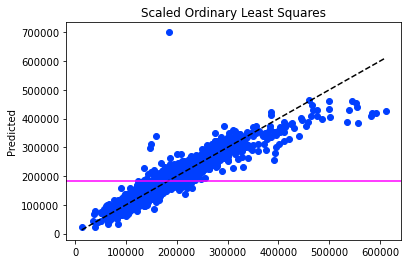

In [167]:
fig,ax = plt.subplots()
ax.scatter(y_train, y_preds)
ax.plot([y.min(),y.max()], [y.min(),y.max()], 'k--')
ax.set_xlabel('')
ax.set_ylabel('Predicted')
plt.axhline(y_train.mean(), c='magenta')
plt.title('Scaled Ordinary Least Squares');
plt.style.use('seaborn-bright')

## Regularization

In [168]:
# Instantiate ridge regularization
ridge = Ridge(alpha=200)
# Fit ridge on scaled training data
ridge.fit(Z_train, y_train)
# Evaluate model using R2.
ridge.score(Z_train, y_train)

0.8526190938326743

In [169]:
cross_val_score(ridge, Z_train, y_train).mean()

0.7713535966529237

In [170]:
# Score ridge on scaled test data
ridge.score(Z_test,y_test)

0.8870004608054068

In [171]:
# Create list of ridge alphas to test
r_alphas = np.logspace(0,5), 100
# Cross-validate over our list of ridge alphas
ridge_cv = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)
# Fit model using best ridge alpha
ridge_cv = ridge_cv.fit(Z_train, y_train)

In [172]:
# Score ridge cross-validate on scaled training data
ridge_cv.score(Z_train,y_train)

0.8559483334996848

In [173]:
# Score ridge cross validate on scaled testing data
ridge_cv.score(Z_test,y_test)

0.8890605831799867

## Lasso Regularization 

In [174]:
# Set up a list of Lasso alphas to test
l_alphas = np.logspace(-3,0,100)
# Cross-validate over our list of Lasso alphas
lasso_cv = LassoCV(alphas = l_alphas, cv=5, max_iter=50_000)
# Fit model using best lasso alpha
lasso_cv.fit(Z_train, y_train);

In [175]:
# Score & print best lasso alpha on scaled training data
print(lasso_cv.score(Z_train, y_train))
# Score & print best lasso alpha on scaled testing data
print(lasso_cv.score(Z_test, y_test))

0.8638031595466438
0.8965585297650924


In [176]:
# Print OLS, Ridge, and Lasso scores for scaled testing and training data for comparison
print(" OLS ".center(18, "="))
print(linreg.score(Z_train, y_train))
print(linreg.score(Z_test, y_test))
print()
print(" Ridge ".center(18, "="))
print(ridge_cv.score(Z_train, y_train))
print(ridge_cv.score(Z_test, y_test))
print()
print(" Lasso ".center(18, "="))
print(lasso_cv.score(Z_train, y_train))
print(lasso_cv.score(Z_test, y_test))

====== OLS =======
0.8638041850801117
0.8965422416820092

===== Ridge ======
0.8559483334996848
0.8890605831799867

===== Lasso ======
0.8638031595466438
0.8965585297650924


> The OLS and Lasso are scoring the best and similarly

> Not over fit

#### Read in test data

In [177]:
# Read in test data
test = pd.read_csv('datasets/test.csv')
# Display first 5 rows of test data
test.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type
0,2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,4,2006,WD
1,2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,8,2006,WD
2,2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,...,0,0,0,NaN,NaN,NaN,0,9,2006,New
3,1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,...,0,0,0,NaN,NaN,NaN,0,7,2007,WD
4,625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,...,0,185,0,NaN,NaN,NaN,0,7,2009,WD


In [178]:
# clean column names with no spaces and all lower case
test.columns = test.columns.str.lower().str.replace(' ', '_')

In [179]:
# Execute pipe function on test data
X,y = custom_pipe(test)

In [180]:
# Predict on X
linreg.predict(X)

array([-1.41131402e+13,  6.43324757e+08, -5.39725405e+12,  2.70068379e+08,
        4.55662972e+08, -2.43151393e+12,  2.65681321e+08,  4.97159819e+08,
       -8.85463989e+12,  3.46879598e+08,  4.67498664e+08,  2.85728610e+08,
        3.81819523e+08, -3.29966320e+13, -1.04361408e+13,  2.26575074e+08,
       -6.44417829e+12,  2.91429138e+08,  4.46415047e+08, -1.03537184e+13,
        3.39599167e+08,  2.73932635e+08,  6.07163395e+08,  2.84501009e+08,
        4.78063784e+08,  2.36090629e+08, -6.25313573e+12, -6.83914565e+12,
        3.71135520e+08, -5.56949915e+11,  2.51860881e+08,  3.07518759e+08,
       -3.22785196e+13,  4.32639698e+08,  5.74398637e+08, -4.69381281e+12,
       -1.00239115e+13,  1.89307670e+08,  2.33795408e+08,  5.03238092e+08,
       -3.42418808e+12, -1.23522592e+13,  4.28508298e+08,  3.20670710e+08,
        5.86965061e+08, -3.55387148e+12, -1.09502649e+13,  2.47467029e+08,
        2.74814482e+08,  3.04375676e+08, -4.17498185e+12, -6.64398039e+12,
        6.65101223e+08, -

In [181]:
# Create new column 'SalePrice' on test dataframe and set to predictions 
test['SalePrice'] = linreg.predict(X)

In [182]:
# save to csv file for submission
test[['id', 'SalePrice']].to_csv('datasets/ames_test_preds.csv', index=False)